In [1]:
# Run this cell to install this project and its dependencies, e.g., on Google Colab

try:
    import sampling_paths  # noqa: F401
except ImportError:
    import sys  # noqa: F401

    !{sys.executable} -m pip install --upgrade 'pip>=25.1'
    try:
        import google.colab  # type: ignore[unresolved-import]  # noqa: F401
    except ImportError:
        !{sys.executable} -m pip install --group notebooks git+https://github.com/jeertmans/sampling-paths.git
    else:
        # Apparently, Google Colab fails to install dependecy groups from a URL
        from tempfile import TemporaryDirectory

        with TemporaryDirectory() as tmp_dir:
            !git clone --filter=blob:none --quiet https://github.com/jeertmans/sampling-paths.git {tmp_dir}
            !cd {tmp_dir} && {sys.executable} -m pip install . --group notebooks

(sampling-paths)=
# Sampling Path Candidates with Machine Learning

:::{important}
This notebook is still in development and may contain incomplete or incorrect information.

Please refer to the previous version of this notebook,
[accessible here](https://differt.rtfd.io/stable/notebooks/sampling_paths.html).
:::

This notebook aims at being a tutorial to reproduce the results presented in the paper
*Transform-Invariant Generative Ray Path Sampling for Efficient Radio Propagation Modeling with Point-to-Point Ray Tracing*,
and assumes you are familiar with its content.

:::{important}
This notebook presents **version 2** of our work on the topic of *sampling path candidates*. You can access **v1**, as presented at the 2025 IEEE International Conference on Machine Learning for Communication and Networking (ICMLCN) in our paper *Towards Generative Ray Path Sampling for Faster Point-to-Point Ray Tracing* {cite}`sampling-icmlcn2025` [by clicking here](https://differt.rtfd.io/icmlcn2025/notebooks/sampling_paths.html).
:::

**You can run it locally or with Google Colab** by clicking on the rocket
at the top of this page!

:::{tip}
On Google Colab, make sure to select a GPU or TPU runtime for a faster experience.
:::

If you find this tutorial useful and plan on using this tool for your publications,
please cite our work, see {ref}`citing`.

:::{warning}
Training the models can take quite some time.

If you want to bypass the training and use a pre-trained model,
you can download the weights from the
[releases page](https://github.com/jeertmans/DiffeRT/releases/tag/icmlcn2025) and
load then with `Model.load_weights`.
:::

## Summary

In our work, we present a Machine Learning model that aims at reducing the computational complexity
of exhaustive point-to-point Ray Tracing by learning how to sample path candidates.
For further details, please refer to the paper.

## Setup

Below are the important steps to properly setup the environment.

### Imports

Unlike for the previous version of our work, we have refactored the codebase to be more modular and reusable.
This means that most of the code is located in separate files,
available on [GitHub](https://github.com/jeertmans/sampling-paths),
and installed as a Python package (`sampling_paths`).

This notebook is meant to be a tutorial on how to use the package to train and use the model, and thus does not contain the implementation details of the model itself.

We need to import quite a few Python modules,
but all of them should be installed with
`pip install --group notebooks git+https://github.com/jeertmans/sampling-paths.git`
(assuming `pip >= 25.1`).
The following cell is hidden by default for readability.

In [35]:
from collections import defaultdict

import jax
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import Array, Float, PRNGKeyArray
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import treescope
from differt.plotting import reuse, set_defaults
from differt.scene import (
    download_sionna_scenes,
)
import equinox as eqx
from differt.utils import safe_divide
from differt.geometry import path_lengths
from functools import partial
from sampling_paths.agent import Agent
from sampling_paths.model import Model
from sampling_paths.utils import (
    BASE_SCENE,
    random_scene,
    train_dataloader,
    validation_scene_keys,
)
from tqdm.notebook import tqdm, trange
from plotly.subplots import make_subplots

### Pretty Printing

Nested structures, like Machine Learning modules, or more generally PyTrees, do not render very nicely by default.
To provide the user with an interactive pretty-printing experience, we use `treescope`:

In [5]:
treescope.basic_interactive_setup()

### JAX Device

While this notebook will run fine all supported JAX devices (i.e., CPU, GPU, and TPU), using a GPU (or a TPU) will usually decrease the computational time by a significant factor.

To check the current active JAX device, use {func}`jax.devices`:

In [6]:
jax.devices()

[CudaDevice(id=0)]

## Generating the training data

For this tutorial, as in the paper,
we restrict ourselves to a simple urban scenario, obtained from Sionna {cite}`sionna`,
from which we will derive random scenes.

In [7]:
download_sionna_scenes()  # Let's download Sionna scenes (from the main branch)

In [8]:
set_defaults(
    "plotly"
)  # Our scene is simple, and Plotly is the best backend for online interactive plots :-)


def make_transparent(fig: go.Figure) -> go.Figure:
    fig.update_scenes(
        xaxis_visible=False, yaxis_visible=False, zaxis_visible=False
    )
    return fig

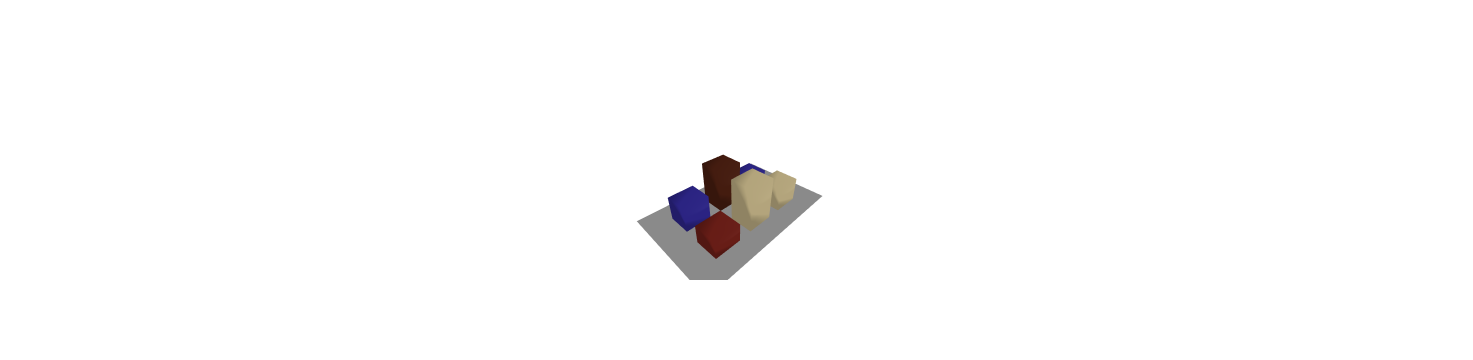

In [9]:
set_defaults(
    "plotly"
)  # Our scene is simple, and Plotly is the best backend for online interactive plots :-)

fig = BASE_SCENE.plot()
make_transparent(fig)

From the `BASE_SCENE` object, we can generate random variations of it.
Two main types of variations are considered here:

1. the number of objects (either triangles or quadrilaterals);
2. and the TX / RX positions.

:::{note}
Unlike with NumPy and other common array libraries,
JAX requires an explicit random key ({func}`jr.key<jax.random.key>`) whenever you need to generate
pseudo-random numbers. While this can lead to more verbose code, this has the
**major advantage** of making random number generation easily reproducible,
even across multiple devices. *You want the same results? Then just pass the same key!*
:::

Below, we demonstrate how to generate (and plot) a random scene.

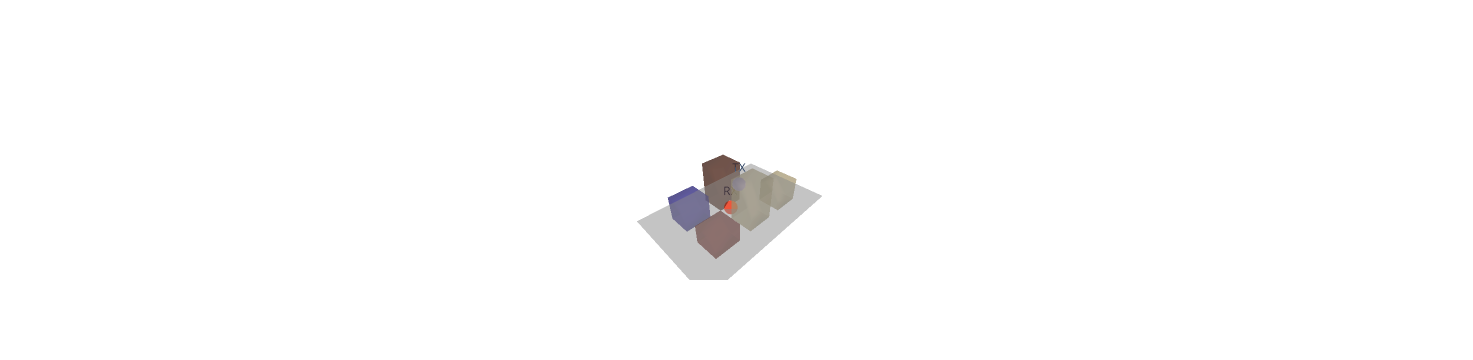

In [25]:
key_example = jr.key(1234)
example_scene = random_scene(key=key_example)
example_fig = example_scene.plot(
    showlegend=False,
    tx_kwargs={"labels": ["TX"]},
    rx_kwargs={"labels": ["RX"]},
    mesh_kwargs={"opacity": 0.5},
)
make_transparent(example_fig)

In the paper, we study other types of random variations,
and they can be specified with optional parameters of the `random_scene` function.

In [11]:
help(random_scene)

Help on _JitWrapper in module sampling_paths.utils:

random_scene(*, min_fill_factor: float = 0.5, max_fill_factor: float = 1.0, tx_z_min: float = 2.0, tx_z_max: float = 50.0, rx_z_min: float = 1.0, rx_z_max: float = 2.0, sample_objects: bool = True, sample_in_canyon: bool = True, include_floor: bool = True, key: Union[jaxtyping.Key[jaxlib._jax.Array, ''], jaxtyping.UInt32[jaxlib._jax.Array, '2']]) -> differt.scene._triangle_scene.TriangleScene
    Return a random scene with one TX and one RX, at random positions, and a random number of objects.
    
    The number of objects is randomly sampled based on a random fill factor.
    
    Args:
        min_fill_factor: The minimum fill factor to be used.
        max_fill_factor: The maximum fill factor to be used.
        tx_z_min: Minimum height of the transmitter.
        tx_z_max: Maximum height of the transmitter.
        rx_z_min: Minimum height of the receiver.
        rx_z_max: Maximum height of the receiver.
        sample_objects:

After, we can trace ray paths in the generated scene and plot them.

Processing path candidates:   0%|          | 0/1 [00:00<?, ?it/s]

(order = 0) Found  1 valid paths our of    1 path candidates.


Processing path candidates:   0%|          | 0/1 [00:00<?, ?it/s]

(order = 1) Found  3 valid paths our of   62 path candidates.


Processing path candidates:   0%|          | 0/1 [00:00<?, ?it/s]

(order = 2) Found  4 valid paths our of 3782 path candidates.


Processing path candidates:   0%|          | 0/1 [00:00<?, ?it/s]

(order = 3) Found  4 valid paths our of 230702 path candidates.


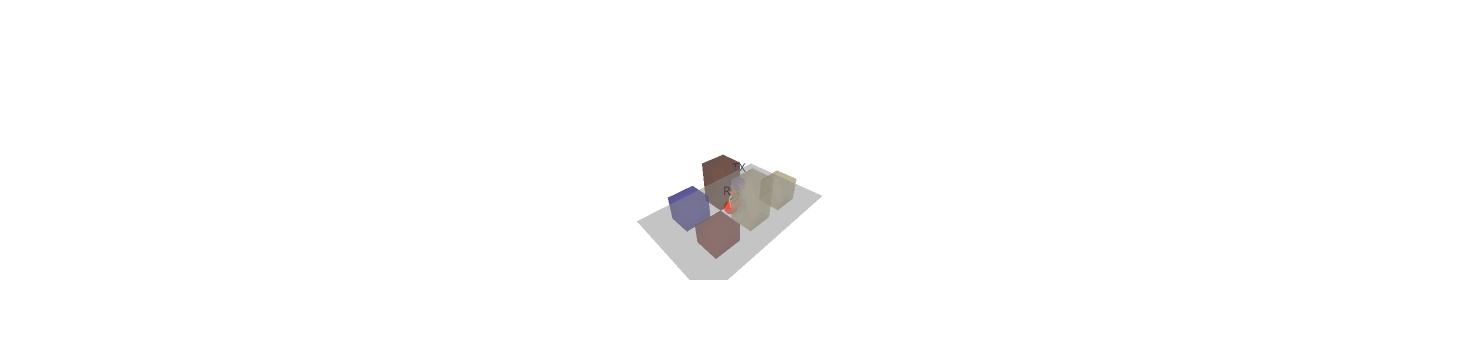

In [26]:
with reuse(figure=example_fig) as fig:
    num_active_primitives = example_scene.mesh.num_active_primitives

    for order in [0, 1, 2, 3]:
        num_valid_paths = 0
        if order == 0:
            num_path_candidates = 1
        else:
            num_path_candidates = num_active_primitives * (
                num_active_primitives - 1
            ) ** (order - 1)
        for paths in tqdm(
            example_scene.compute_paths(order=order, chunk_size=1_000_000),
            desc="Processing path candidates",
            leave=False,
        ):
            num_valid_paths += paths.num_valid_paths
        paths.plot(showlegend=False)
        print(
            f"(order = {order}) Found {num_valid_paths:2d} valid paths our of {num_path_candidates:4d} path candidates."
        )

fig

We then collect some statistics about the scenes we are training on.

	Statistics for order = 0:
	- an average of 1 path candidates exist;
	- out of which 100.00000000% of the paths are valid
	- and 100.00000000%% of the scenes contained at least one valid path.
	Statistics for order = 1:
	- an average of 56 path candidates exist;
	- out of which 4.87072431% of the paths are valid
	- and 100.00000000%% of the scenes contained at least one valid path.
	Statistics for order = 2:
	- an average of 3368 path candidates exist;
	- out of which 0.08461884% of the paths are valid
	- and 91.50000215%% of the scenes contained at least one valid path.
	Statistics for order = 3:
	- an average of 211941 path candidates exist;
	- out of which 0.00109444% of the paths are valid
	- and 57.90000558%% of the scenes contained at least one valid path.


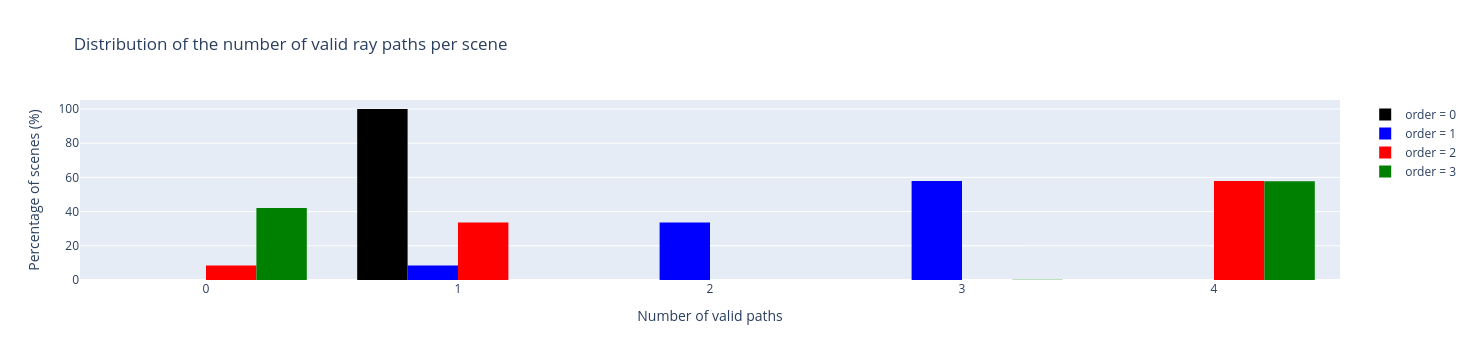

In [13]:
key_stats = jr.key(1234)

scenes = train_dataloader(key=key_stats)

num_valid_paths = defaultdict(list)  # Number of valid paths
num_total_paths = defaultdict(list)  # Total number of path (candidates)

colors = {0: "black", 1: "blue", 2: "red", 3: "green"}

for _ in trange(
    1_000,
    desc="Collecting statistics over many realizations",
    leave=False,
):
    scene = next(scenes)
    num_active_primitives = scene.mesh.num_active_primitives
    for order in colors:
        num_valid_paths[order].append(0)
        if order == 0:
            num_path_candidates = 1
        else:
            num_path_candidates = num_active_primitives * (
                num_active_primitives - 1
            ) ** (order - 1)
        num_total_paths[order].append(num_path_candidates)
        for paths in scene.compute_paths(order=order, chunk_size=100_000):
            num_valid_paths[order][-1] += paths.mask.sum()

fig = go.Figure()
for order, color in colors.items():
    print(f"\tStatistics for {order = }:")
    num_valid = jnp.array(num_valid_paths[order])
    num_total = jnp.array(num_total_paths[order])
    where = num_total != 0  # We discard rare cases without any candidate
    avg_total = int(num_total.mean(where=where))
    frac = float((num_valid / num_total).mean(where=where))
    frac_one = float((num_valid > 0).sum(where=where) / where.sum())
    print(
        f"\t- an average of {avg_total} path candidates exist;\n"
        f"\t- out of which {frac:.8%} of the paths are valid\n"
        f"\t- and {frac_one:.8%}% of the scenes contained at least one valid path."
    )
    fig.add_histogram(
        x=num_valid,
        histnorm="percent",
        name=f"{order = }",
        marker_color=color,
    )

fig.update_layout(
    title="Distribution of the number of valid ray paths per scene",
    xaxis_title="Number of valid paths",
    yaxis_title="Percentage of scenes (%)",
)

## Reward function

As for every reinforcement learning problem, we need to define a reward function
that will guide the training of our model.

Here, we use a binary reward function that indicates if a generated path candidate
leads to a valid ray path or not.

When computing paths with
{meth}`TriangleScene.compute_paths<differt.scene.TriangleScene.compute_paths>`,
assuming default parameters,
the {attr}`Paths.mask<differt.geometry.Paths.mask>` attribute
is a boolean array where each entry indicates if the corresponding ray
path is valid or not. As we only have one pair of TX and RX, the sum
of all entries in this mask, when converted to floating point values,
is either 1 or 0.

### Differentiable reward

As {mod}`differt` is a differentiable library, thanks to JAX,
the reward function will be differentiable with respect to its arguments.

### Simulating non-differentiable reward

In our previous work, we already observed that using a non-differentiable reward
leads to worse training performance.

To observe this effect, you can use {func}`jax.lax.stop_gradient`
to prevent gradients from flowing through the reward function.
To do so, when creating the model (see below), pass the following reward function:

```python
Model(
    ...,
    reward_fn=lambda path_candidate, scene: jax.lax.stop_gradient(
        reward_fn(path_candidate, scene)
    ),
)
```

## Machine Learning model

Our model is made of four modules: an outer flow model, that returns the flows between a parent state and its child states,
and three inner models, each encoding different aspects of the scene.

Model's internals are detailed in the paper and will not be discussed here.

Below, we instantiate the model with default parameters.

In [14]:
order = 2  # Change this to try different path orders
model_key = jr.key(1234)
model = Model(
    order=order, num_embeddings=64, width_size=128, depth=2, key=model_key
)
model

Model(
  order=2,
  action_masking=True,
  distance_based_weighting=True,
  objects_encoder=ObjectsEncoder(
    out_size=64,
    mlp=MLP(
      layers=(
        Linear(
          weight=f32[128,9],
          bias=f32[128],
          in_features=9,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=f32[128,128],
          bias=f32[128],
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=f32[64,128],
          bias=f32[64],
          in_features=128,
          out_features=64,
          use_bias=True
        )
      ),
      activation=<PjitFunction of <function relu at 0x7aff957713a0>>,
      final_activation=<function <lambda>>,
      use_bias=True,
      use_final_bias=True,
      in_size=9,
      out_size=64,
      width_size=128,
      depth=2
    )
  ),
  scene_encoder=SceneEncoder(
    out_size=64,
    rho=MLP(
      layers=(
        Linear(
          weight=f32[128,64],
          bias=f32[128],
          in_features=64,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=f32[128,128],
          bias=f32[128],
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=f32[64,128],
          bias=f32[64],
          in_features=128,
          out_features=64,
          use_bias=True
        )
      ),
      activation=<PjitFunction of <function relu at 0x7aff957713a0>>,
      final_activation=<function <lambda>>,
      use_bias=True,
      use_final_bias=True,
      in_size=64,
      out_size=64,
      width_size=128,
      depth=2
    )
  ),
  state_encoder=StateEncoder(
    out_size=128,
    linear=Linear(
      weight=f32[128,128],
      bias=f32[128],
      in_features=128,
      out_features=128,
      use_bias=True
    )
  ),
  flows=Flows(
    mlp=MLP(
      layers=(
        Linear(
          weight=f32[128,256],
          bias=f32[128],
          in_features=256,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=f32[128,128],
          bias=f32[128],
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=f32[1,128],
          bias=f32[1],
          in_features=128,
          out_features='scalar',
          use_bias=True
        )
      ),
      activation=<PjitFunction of <function leaky_relu at 0x7aff95772980>>,
      final_activation=<PjitFunction of <function exp at 0x7aff95abccc0>>,
      use_bias=True,
      use_final_bias=True,
      in_size=256,
      out_size='scalar',
      width_size=128,
      depth=2
    ),
    dropout=Dropout(p=0.0, inference=False)
  ),
  epsilon=weak_f32[],
  inference=False,
  reward_fn=<function reward_fn>
)

## Training with an agent

To train the model, we define an agent that will handle the training loop for us.

This is mainly syntactic sugar to avoid writing boilerplate code,
as the agent does not add any new functionality to the model itself.

Instead, it provides a convenient interface to train the model over multiple epochs,
track metrics, and alternative from the *standard* training step and the *replay buffer* training step, which are automatically handled by the agent's `train` method.

To optimize the model's parameters, we rely on the `optax` module that provides
convenient optimizers, from which we use the popular {func}`optax.adam` optimizer.

Every few training steps, we will as the agent to evaluate the model's performance
to obtain the curves presented in the paper.

In [15]:
agent = Agent(
    model=model,
    batch_size=64,
    min_epsilon=0.1,
)
agent

Agent(
  batch_size=64,
  replay_symmetric=False,
  scene_fn=_JitWrapper(
    fn='random_scene',
    filter_warning=False,
    donate_first=False,
    donate_rest=False
  ),
  model=Model(
    order=2,
    action_masking=True,
    distance_based_weighting=True,
    objects_encoder=ObjectsEncoder(
      out_size=64,
      mlp=MLP(
        layers=(
          Linear(
            weight=f32[128,9],
            bias=f32[128],
            in_features=9,
            out_features=128,
            use_bias=True
          ),
          Linear(
            weight=f32[128,128],
            bias=f32[128],
            in_features=128,
            out_features=128,
            use_bias=True
          ),
          Linear(
            weight=f32[64,128],
            bias=f32[64],
            in_features=128,
            out_features=64,
            use_bias=True
          )
        ),
        activation=<PjitFunction of <function relu at 0x7aff957713a0>>,
        final_activation=<function <lambda>>,
        use_bias=True,
        use_final_bias=True,
        in_size=9,
        out_size=64,
        width_size=128,
        depth=2
      )
    ),
    scene_encoder=SceneEncoder(
      out_size=64,
      rho=MLP(
        layers=(
          Linear(
            weight=f32[128,64],
            bias=f32[128],
            in_features=64,
            out_features=128,
            use_bias=True
          ),
          Linear(
            weight=f32[128,128],
            bias=f32[128],
            in_features=128,
            out_features=128,
            use_bias=True
          ),
          Linear(
            weight=f32[64,128],
            bias=f32[64],
            in_features=128,
            out_features=64,
            use_bias=True
          )
        ),
        activation=<PjitFunction of <function relu at 0x7aff957713a0>>,
        final_activation=<function <lambda>>,
        use_bias=True,
        use_final_bias=True,
        in_size=64,
        out_size=64,
        width_size=128,
        depth=2
      )
    ),
    state_encoder=StateEncoder(
      out_size=128,
      linear=Linear(
        weight=f32[128,128],
        bias=f32[128],
        in_features=128,
        out_features=128,
        use_bias=True
      )
    ),
    flows=Flows(
      mlp=MLP(
        layers=(
          Linear(
            weight=f32[128,256],
            bias=f32[128],
            in_features=256,
            out_features=128,
            use_bias=True
          ),
          Linear(
            weight=f32[128,128],
            bias=f32[128],
            in_features=128,
            out_features=128,
            use_bias=True
          ),
          Linear(
            weight=f32[1,128],
            bias=f32[1],
            in_features=128,
            out_features='scalar',
            use_bias=True
          )
        ),
        activation=<PjitFunction of <function leaky_relu at 0x7aff95772980>>,
        final_activation=<PjitFunction of <function exp at 0x7aff95abccc0>>,
        use_bias=True,
        use_final_bias=True,
        in_size=256,
        out_size='scalar',
        width_size=128,
        depth=2
      ),
      dropout=Dropout(p=0.0, inference=False)
    ),
    epsilon=weak_f32[],
    inference=False,
    reward_fn=<function reward_fn>
  ),
  optim=GradientTransformationExtraArgs(
    init=<function chain.<locals>.init_fn>,
    update=<function chain.<locals>.update_fn>
  ),
  opt_state=(
    (
      ScaleByAdamState(
        count=i32[],
        mu=Model(
          order=2,
          action_masking=True,
          distance_based_weighting=True,
          objects_encoder=ObjectsEncoder(
            out_size=64,
            mlp=MLP(
              layers=(
                Linear(
                  weight=f32[128,9],
                  bias=f32[128],
                  in_features=9,
                  out_features=128,
                  use_bias=True
                ),
                Linear(
                  weight=f32[128,128],
                  bias=f32[128]

In [16]:
key_training = jr.key(1234)
key_episodes, key_valid_samples = jr.split(key_training, 2)
valid_keys = validation_scene_keys(
    order=order, num_scenes=100, key=key_valid_samples
)

num_episodes = 10_000

evaluate_every = 100

episodes = []
loss_values = []
success_rates = []
hit_rates = []
fill_rates = []

progress_bar = tqdm(jr.split(key_episodes, num_episodes))

for episode, key_episode in enumerate(progress_bar):
    scene_key, train_key, eval_key = jr.split(key_episode, 3)

    # Train
    agent, loss_value = agent.train(scene_key, key=train_key)

    # Evaluate
    if episode % evaluate_every == 0:
        accuracy, hit_rate = agent.evaluate(valid_keys, key=eval_key)

        progress_bar.set_description(
            f"loss: {loss_value:.1e}, "
            f"success rate: {accuracy:.2%}, "
            f"hit rate: {hit_rate:.2%}"
            + (
                f", buffer filled: {agent.replay_buffer.fill_ratio:.2%}"
                if agent.replay_buffer is not None
                else ""
            )
        )

        episodes.append(episode)
        loss_values.append(loss_value)
        success_rates.append(100 * accuracy)
        hit_rates.append(100 * hit_rate)
        if agent.replay_buffer is not None:
            fill_rates.append(100 * agent.replay_buffer.fill_ratio)


agent

Selecting validation scenes:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Agent(
  batch_size=64,
  replay_symmetric=False,
  scene_fn=_JitWrapper(
    fn='random_scene',
    filter_warning=False,
    donate_first=False,
    donate_rest=False
  ),
  model=Model(
    order=2,
    action_masking=True,
    distance_based_weighting=True,
    objects_encoder=ObjectsEncoder(
      out_size=64,
      mlp=MLP(
        layers=(
          Linear(
            weight=f32[128,9],
            bias=f32[128],
            in_features=9,
            out_features=128,
            use_bias=True
          ),
          Linear(
            weight=f32[128,128],
            bias=f32[128],
            in_features=128,
            out_features=128,
            use_bias=True
          ),
          Linear(
            weight=f32[64,128],
            bias=f32[64],
            in_features=128,
            out_features=64,
            use_bias=True
          )
        ),
        activation=<PjitFunction of <function relu at 0x7aff957713a0>>,
        final_activation=<function <lambda>>,
        use_bias=True,
        use_final_bias=True,
        in_size=9,
        out_size=64,
        width_size=128,
        depth=2
      )
    ),
    scene_encoder=SceneEncoder(
      out_size=64,
      rho=MLP(
        layers=(
          Linear(
            weight=f32[128,64],
            bias=f32[128],
            in_features=64,
            out_features=128,
            use_bias=True
          ),
          Linear(
            weight=f32[128,128],
            bias=f32[128],
            in_features=128,
            out_features=128,
            use_bias=True
          ),
          Linear(
            weight=f32[64,128],
            bias=f32[64],
            in_features=128,
            out_features=64,
            use_bias=True
          )
        ),
        activation=<PjitFunction of <function relu at 0x7aff957713a0>>,
        final_activation=<function <lambda>>,
        use_bias=True,
        use_final_bias=True,
        in_size=64,
        out_size=64,
        width_size=128,
        depth=2
      )
    ),
    state_encoder=StateEncoder(
      out_size=128,
      linear=Linear(
        weight=f32[128,128],
        bias=f32[128],
        in_features=128,
        out_features=128,
        use_bias=True
      )
    ),
    flows=Flows(
      mlp=MLP(
        layers=(
          Linear(
            weight=f32[128,256],
            bias=f32[128],
            in_features=256,
            out_features=128,
            use_bias=True
          ),
          Linear(
            weight=f32[128,128],
            bias=f32[128],
            in_features=128,
            out_features=128,
            use_bias=True
          ),
          Linear(
            weight=f32[1,128],
            bias=f32[1],
            in_features=128,
            out_features='scalar',
            use_bias=True
          )
        ),
        activation=<PjitFunction of <function leaky_relu at 0x7aff95772980>>,
        final_activation=<PjitFunction of <function exp at 0x7aff95abccc0>>,
        use_bias=True,
        use_final_bias=True,
        in_size=256,
        out_size='scalar',
        width_size=128,
        depth=2
      ),
      dropout=Dropout(p=0.0, inference=False)
    ),
    epsilon=weak_f32[],
    inference=False,
    reward_fn=<function reward_fn>
  ),
  optim=GradientTransformationExtraArgs(
    init=<function chain.<locals>.init_fn>,
    update=<function chain.<locals>.update_fn>
  ),
  opt_state=(
    (
      ScaleByAdamState(
        count=i32[],
        mu=Model(
          order=2,
          action_masking=True,
          distance_based_weighting=True,
          objects_encoder=ObjectsEncoder(
            out_size=64,
            mlp=MLP(
              layers=(
                Linear(
                  weight=f32[128,9],
                  bias=f32[128],
                  in_features=9,
                  out_features=128,
                  use_bias=True
                ),
                Linear(
                  weight=f32[128,128],
                  bias=f32[128]

In [17]:
agent.replay_buffer

ReplayBuffer(
  capacity=10000,
  sample_with_replacement=False,
  scene_keys=key<fry>[10000],
  path_candidates=i32[10000,2],
  rewards=f32[10000],
  counter=i32[]
)

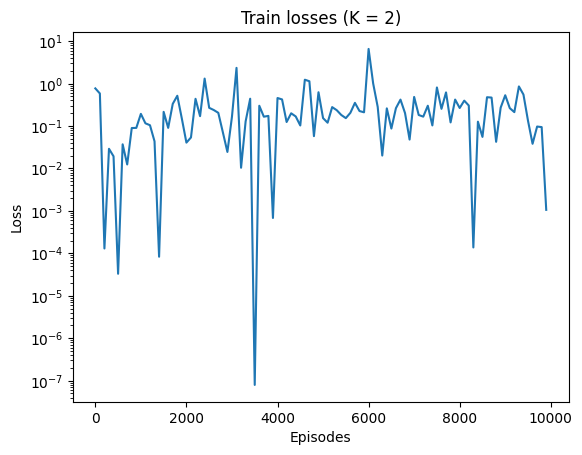

In [18]:
plt.figure()
plt.title(f"Train losses (K = {order})")
plt.semilogy(episodes, loss_values)
plt.xlabel("Training episodes")
plt.ylabel("Loss")
plt.show()

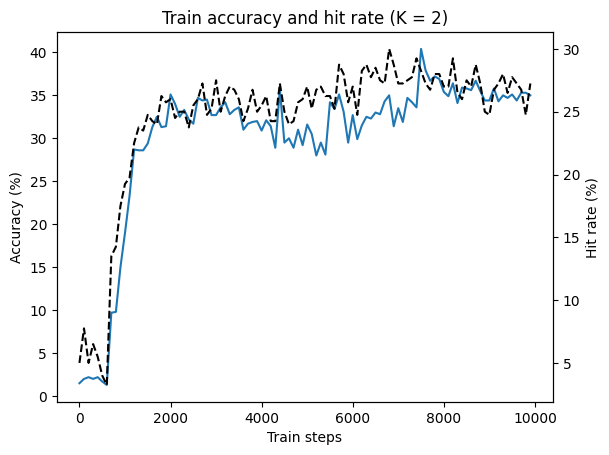

In [19]:
_, ax1 = plt.subplots()
ax1.set_title(f"Train accuracy and hit rate (K = {order})")
ax1.set_xlabel("Training episodes")
ax1.set_ylabel("Accuracy (%)")
ax1.plot(episodes, success_rates, label="Accuracy")
ax2 = ax1.twinx()
ax2.set_ylabel("Hit rate (%)")
ax2.plot(episodes, hit_rates, "k--", label="Hit Rate")
plt.show()

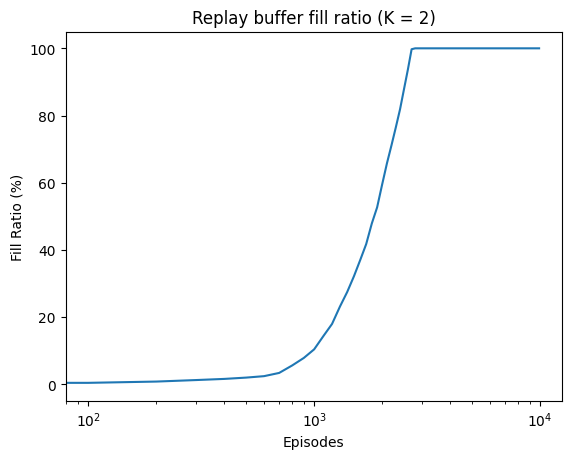

In [22]:
if len(fill_rates) > 0:
    plt.figure()
    plt.title(f"Replay buffer fill ratio (K = {order})")
    plt.semilogx(episodes, fill_rates, label="Fill Ratio")
    plt.xlabel("Training episodes")
    plt.ylabel("Fill Ratio (%)")
    plt.show()

## Using the model for coverage map estimation

In [43]:
@partial(jax.vmap, in_axes=(0, None, None, None, None))
@partial(jax.vmap, in_axes=(0, None, None, None, None))
@jax.custom_batching.sequential_vmap
def compute_cm(receiver: Float[Array, "3"], base_scene, model, batch_size: int, key: PRNGKeyArray | None) -> Float[Array, "*batch"]:
    scene = eqx.tree_at(lambda s: s.receivers, base_scene, receiver)
    if key is not None:
        path_candidates = jax.vmap(lambda key: model(scene, key=key))(
            jr.split(key, batch_size)
        )
        paths = scene.compute_paths(path_candidates=path_candidates)
    else:
        paths = scene.compute_paths(order=model.order)
    r = path_lengths(paths.vertices)
    e = safe_divide(1.0, r)
    return e * e


batch = (20, 20)
z0 = 0.5
base_scene = eqx.tree_at(lambda s:s.transmitters, BASE_SCENE, jnp.array([[0.0, 0.0, 32.0]]))
receivers = base_scene.with_receivers_grid(*batch, height=z0).receivers

# Only needed for plotting purposes
x, y, _ = jnp.unstack(receivers, axis=-1)

fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{"type": "scene"}, {"type": "scene"}]],
)

with reuse(figure=fig) as fig:
    scene.plot(
        tx_kwargs={"marker_color": "#636EFA"}, showlegend=False, row=1, col=1
    )
    scene.plot(
        tx_kwargs={"marker_color": "#636EFA"}, showlegend=False, row=1, col=2
    )

    P_m = compute_cm(receivers, base_scene, model, 10, None)
    P_e = compute_cm(receivers, base_scene, model, 10, jr.key(0))

    draw_image(
        P_m,
        x=x[0, :],
        y=y[:, 0],
        z0=z0,
        colorbar={"title": "Gain (dB)"},
        colorscale="viridis",
        cmin=float(G_min),
        cmax=float(G_max),
        row=1,
        col=1,
        showscale=False,
    )
    draw_image(
        P_e,
        x=x[0, :],
        y=y[:, 0],
        z0=z0,
        colorbar={"title": "Gain (dB)"},
        colorscale="viridis",
        cmin=float(G_min),
        cmax=float(G_max),
        row=1,
        col=2,
    )
fig

TypeError: Argument '<jax._src.custom_derivatives.custom_jvp object at 0x7aff9576d8d0>' of type '<class 'jax._src.custom_derivatives.custom_jvp'>' is not a valid JAX type